## Useful imports

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import cv2
from sklearn.model_selection import train_test_split

## Mounting drive to read data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Unzipping data

In [3]:
from IPython.display import clear_output
# Modify the first path to be the path of the data in your drive
!unzip /content/drive/MyDrive/PatternRecognition/Assignment1Data/archive.zip -d /content/sample_data/archive
clear_output(wait=False)

## Read images

### Showing an example from the data to make sure everything is OK

[48. 49. 45. ... 47. 46. 46.]


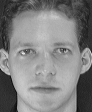

In [4]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('/content/sample_data/archive/s1/1.pgm', cv2.IMREAD_UNCHANGED)
print(np.array(img, dtype='float64').flatten())
cv2_imshow(img)

In [ ]:
#@title 
path = '/content/sample_data/archive/s*'
dirs = glob.glob(path)
images = np.ones((1, 10304))
labels=np.array([])
for i, dir in enumerate(dirs, 1):
    for f in glob.glob(dir+"/*"):
        img = cv2.imread(f, 0)
        img = np.reshape(img, (1, 10304))
        images = np.append(images, img, axis=0)
        labels = np.append(labels, i)
labels=np.array(labels)
images=images[1:,]

In [ ]:
#@title
X_train=images[1::2] 
X_test=images[0::2]
y_train=labels[1::2] 
y_test=labels[0::2]

In [ ]:
#@title
X_train.shape

### Reading the image from the folders and adding the data in the images matrix with labeling in labels vector

In [5]:
images = np.ones((1, 10304))
labels=np.array([])
for i in range(1,41):
  photos=[i for i in range(1, 10+1)]
  for photo in photos:
    img = cv2.imread('/content/sample_data/archive/s'+str(i)+"/"+str(photo)+".pgm",0) # zero for gray scale
    img = np.reshape(img, (1, 10304))
    images = np.append(images, img, axis=0)
    labels = np.append(labels, i)
labels=np.array(labels)
images=images[1:,]

### Checking for images correctness



In [6]:
images

array([[ 48.,  49.,  45., ...,  47.,  46.,  46.],
       [ 60.,  60.,  62., ...,  32.,  34.,  34.],
       [ 39.,  44.,  53., ...,  29.,  26.,  29.],
       ...,
       [125., 119., 124., ...,  36.,  39.,  40.],
       [119., 120., 120., ...,  89.,  94.,  85.],
       [125., 124., 124., ...,  36.,  35.,  34.]])

In [ ]:
#@title
df=pd.DataFrame(data=images)
df['target']=labels
df.head()

In [ ]:
#@title
sns.countplot(x='target', data=df)
sns.set(rc={'figure.figsize':(40,10)})

##Train Test Split

In [7]:
X_train=images[1::2] # Odd
X_test=images[0::2]  # Even
y_train=labels[1::2] # Odd
y_test=labels[0::2]  # Even

In [ ]:
#@title
df_test = df[(df.index) % 2 == 0]
df_train = df[(df.index) % 2 != 0]

In [ ]:
#@title
df_train

### Checking dimensions

In [8]:
print(X_train.shape)
print(X_test.shape)

(200, 10304)
(200, 10304)


## PCA

In [ ]:
#Calculating mean
def calculate_mean(data):
    return np.mean(data,axis=0,keepdims=True)

#Centralize data
def centeralize(data):
    return data - calculate_mean(data)

#Covariance Matrix
def calculate_covariance_matrix(data):
    z = centeralize(data)
    return (np.matmul(np.transpose(z), z)) / len(data)

#Calculating Eigen values & Eigen vectors
def calculate_eigen_vectors(data):
    cov = calculate_covariance_matrix(data)
    eig_values, eig_vectors = np.linalg.eigh(cov)  
    #Sorting eigenvalues and eigenvectors respectivily
    idx = eig_values.argsort()[::-1]   
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]
    return eig_values, eig_vectors

#Choosing dimensionality
def dimensionality(alpha, eig_values):
    sum = np.sum(eig_values)
    r = 0
    i = 0
    for value in eig_values: 
        r = r + eig_values[i]
        i = i + 1
        if (r / float(sum) >= alpha):
            break
    return i

def reduce_matrix(r, matrix):
  U = matrix[:,:r]
  return U

def PCA(alpha,X_train,X_test):
    eig_values, eig_vectors = calculate_eigen_vectors(X_train)
    print("Eigenvectors shape = "+str(eig_vectors.shape))
    r = dimensionality(alpha, eig_values)
    print("r = ", r)
    U = reduce_matrix(r, eig_vectors)
    print("U shape = "+str(U.shape))
    projected_training = np.dot(X_train, U)
    projected_testing = np.dot(X_test, U)
    print("projected_training shape = "+str(projected_training.shape))
    print("projected_testing shape = "+str(projected_testing.shape))
    return projected_training, projected_testing


In [ ]:
#@title
X_train=df_train.drop(columns='target')
X_test=df_test.drop(columns='target')
y_train=df_train['target']
y_test=df_test['target']

## Using KNN

### First we make prediction using k=1 , after we get the projection matrices , we store them to use them again in another Ks , also in every trial we store accuracy to be used in plots

In [ ]:
def test_pca(X_train,X_test,y_train,y_test):
  accuracy=[]
  alphas_dict_proj={} # each key represents a value of alpha , the value of each key is a list containing two matrices , first is proj train , second is proj test
  alphas_dict_acc={}
  alphas_dict_acc["0.8"]=[]
  alphas_dict_acc["0.85"]=[]
  alphas_dict_acc["0.9"]=[]
  alphas_dict_acc["0.95"]=[]
  model = KNeighborsClassifier(n_neighbors=1)
  alphas=[0.8,0.85,0.9,0.95]
  for alpha in alphas:
    matrices=[]
    projected_training, projected_testing = PCA(alpha,X_train,X_test)
    matrices.append(projected_training)
    matrices.append(projected_testing)
    alphas_dict_proj[str(alpha)]=matrices
    model.fit(projected_training, y_train)
    test_pred = model.predict(projected_testing)
    #print(classification_report(y_test, test_pred))
    acc=accuracy_score(y_test, test_pred)
    print(acc)
    alphas_dict_acc[str(alpha)].append(acc)
    accuracy.append(acc)
  import matplotlib.pyplot as plt
  plt.figure(figsize=(15,5))
  plt.plot(alphas, accuracy,'--bo', label='line with marker')
  plt.xlabel("Alpha")
  plt.ylabel("Accuracy")
  plt.title("Accuracy using K = 1")
  plt.show()
  avg_accuracies=[]
  avg_accuracies.append(sum(accuracy)/len(accuracy))
  Ks=[3,5,7]
  plt.figure(figsize=(10,10))
  index=1
  for k in Ks:
    kAccuracy=[]
    model = KNeighborsClassifier(n_neighbors=k)
    alphas=[0.8,0.85,0.9,0.95]
    for alpha in alphas:
      projected_training=alphas_dict_proj[str(alpha)][0]
      projected_testing=alphas_dict_proj[str(alpha)][1]
      model.fit(projected_training, y_train)
      test_pred = model.predict(projected_testing)
      #print(classification_report(y_test, test_pred))
      acc=accuracy_score(y_test, test_pred)
      print(acc)
      alphas_dict_acc[str(alpha)].append(acc)
      kAccuracy.append(accuracy_score(y_test, test_pred))
    print("Done for alpha = "+str(alpha)+"\n======================\n")
    plt.subplot(2, 2, index)
    index+=1
    plt.plot(alphas, kAccuracy,'--bo', label='line with marker')
    plt.title("Accuracy using K = "+ str(k))
    plt.xlabel("Alpha")
    plt.ylabel("Accuracy")
    avg_accuracies.append(sum(kAccuracy)/len(kAccuracy))
  index=1
  plt.figure(figsize=(10,10))
  for alpha in alphas:
    plt.subplot(2, 2, index)
    index+=1
    plt.plot([1,3,5,7], alphas_dict_acc[str(alpha)],'--bo', label='line with marker')
    plt.xlabel("K Value")
    plt.ylabel("Accuracy")
    plt.title("Different accuracies for alpha = "+str(alpha))
  index=1
  plt.figure(figsize=(10,10))
  plt.subplot(2, 2, index)
  index+=1
  plt.plot([1,3,5,7], avg_accuracies,'--bo', label='line with marker')
  plt.xlabel("K Value")
  plt.ylabel("Avg Accuracy")
  plt.title("Average accuracy for different values of K")

In [ ]:
#@title
accuracy=[]
alphas_dict_proj={} # each key represents a value of alpha , the value of each key is a list containing two matrices , first is proj train , second is proj test
alphas_dict_acc={}
alphas_dict_acc["0.8"]=[]
alphas_dict_acc["0.85"]=[]
alphas_dict_acc["0.9"]=[]
alphas_dict_acc["0.95"]=[]

In [ ]:
#@title
model = KNeighborsClassifier(n_neighbors=1)
alphas=[0.8,0.85,0.9,0.95]
for alpha in alphas:
  matrices=[]
  projected_training, projected_testing = PCA(alpha,X_train,X_test)
  matrices.append(projected_training)
  matrices.append(projected_testing)
  alphas_dict_proj[str(alpha)]=matrices
  model.fit(projected_training, y_train)
  test_pred = model.predict(projected_testing)
  #print(classification_report(y_test, test_pred))
  acc=accuracy_score(y_test, test_pred)
  print(acc)
  alphas_dict_acc[str(alpha)].append(acc)
  accuracy.append(acc)

In [ ]:
#@title
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(alphas, accuracy,'--bo', label='line with marker')
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy using K = 1")
plt.show()

### From the previous plot , we can estimate that accuracy increases with increasing alpha , it may decrease a little bit but still good

In [ ]:
#@title
avg_accuracies=[]
avg_accuracies.append(sum(accuracy)/len(accuracy))

## Classifier tuning PCA

In [ ]:
#@title
Ks=[3,5,7]

In [ ]:
#@title
plt.figure(figsize=(10,10))
index=1
for k in Ks:
  kAccuracy=[]
  model = KNeighborsClassifier(n_neighbors=k)
  alphas=[0.8,0.85,0.9,0.95]
  for alpha in alphas:
    projected_training=alphas_dict_proj[str(alpha)][0]
    projected_testing=alphas_dict_proj[str(alpha)][1]
    model.fit(projected_training, y_train)
    test_pred = model.predict(projected_testing)
    #print(classification_report(y_test, test_pred))
    acc=accuracy_score(y_test, test_pred)
    print(acc)
    alphas_dict_acc[str(alpha)].append(acc)
    kAccuracy.append(accuracy_score(y_test, test_pred))
  print("Done for alpha = "+str(alpha)+"\n======================\n")
  plt.subplot(2, 2, index)
  index+=1
  plt.plot(alphas, kAccuracy,'--bo', label='line with marker')
  plt.title("Accuracy using K = "+ str(k))
  plt.xlabel("Alpha")
  plt.ylabel("Accuracy")
  avg_accuracies.append(sum(kAccuracy)/len(kAccuracy))

### From the previous plot , We deduce that increasing value of K decreases the accuracy with PCA , and it is normal as PCA isn't designed for classification

In [ ]:
#@title
index=1
plt.figure(figsize=(10,10))
for alpha in alphas:
  plt.subplot(2, 2, index)
  index+=1
  plt.plot([1,3,5,7], alphas_dict_acc[str(alpha)],'--bo', label='line with marker')
  plt.xlabel("K Value")
  plt.ylabel("Accuracy")
  plt.title("Different accuracies for alpha = "+str(alpha))

### The previous plot showt that for every alpha value , the accuracy is decreasing with increasing K , which proofs our convention

In [ ]:
#@title
avg_accuracies=avg_accuracies[:4]

In [ ]:
#@title
index=1
plt.figure(figsize=(10,10))
plt.subplot(2, 2, index)
index+=1
plt.plot([1,3,5,7], avg_accuracies,'--bo', label='line with marker')
plt.xlabel("K Value")
plt.ylabel("Avg Accuracy")
plt.title("Average accuracy for different values of K")

### Another insight to prove our convention ,  the average accuracy decreases as we increase value of K

# LDA

## Calculating classes means

In [ ]:
def get_classes_means(X_train):
  classes_means=np.zeros((40,10304))
  classes_matrix=[] # to be used in another steps
  for i in range(40):
    class_matrix=X_train[i*5:(i+1)*5,:]
    classes_matrix.append(class_matrix)
    class_mean=np.mean(class_matrix,axis=0,keepdims=True)
    classes_means[i]=class_mean
  return classes_means,classes_matrix
def between_class_scatter(X_train,classes_means):
  all_classes_mean=np.mean(X_train,axis=0,keepdims=True)
  Sb=np.zeros((10304,10304))
  all_classes_mean=all_classes_mean.reshape(10304,1)
  for i in range(40):
    class_mean=classes_means[i].reshape(10304,1)
    Sb+=5*np.dot((class_mean-all_classes_mean),(class_mean-all_classes_mean).T)
  return Sb
def center_class_matrix(classes_matrix,classes_means):
  Z=[]
  for i in range(40):
    centered=classes_matrix[i]-classes_means[i]
    Z.append(centered)
  return Z
def class_scatter_matrix(Z):
  S=np.ones((10304,10304))
  for i in range(40):
    S+=np.dot(Z[i].T,Z[i])
  return S
def project(data,proj_matrix):
  return np.dot(proj_matrix,data.T).T
def LDA(X_train,X_test):
  classes_means,classes_matrix=get_classes_means(X_train)
  Sb=between_class_scatter(X_train,classes_means)
  Z=center_class_matrix(classes_matrix,classes_means)
  S=class_scatter_matrix(Z)
  eig_values,eig_vectors=np.linalg.eigh(np.dot(np.linalg.inv(S),Sb))
  eig_values = eig_values[::-1]
  eig_vectors = eig_vectors[:,::-1]
  selected=eig_vectors[:,:39]
  train_proj,test_proj=project(X_train,selected.T),project(X_test,selected.T)
  return train_proj,test_proj

In [ ]:
def test_lda(X_train,X_test,y_train,y_test):
  train_proj,test_proj=LDA(X_train,X_test)
  Ks=[1,3,5,7]
  lda_accuracies=[]
  for k in Ks:
    model=KNeighborsClassifier(n_neighbors=k)
    model.fit(train_proj, y_train)
    test_pred = model.predict(test_proj)
    acc=accuracy_score(y_test, test_pred)
    print("Accuracy using k = "+str(k)+" = "+str(acc))
    lda_accuracies.append(acc)
  import matplotlib.pyplot as plt
  plt.figure(figsize=(10,5))
  plt.plot(Ks, lda_accuracies,'--bo', label='line with marker')
  plt.title("Tunung K parameter using LDA")
  plt.xlabel("K")
  plt.ylabel("Accuracy")

In [ ]:
#@title
classes_means=np.zeros((40,10304))
classes_matrix=[] # to be used in another steps
for i in range(40):
  class_matrix=X_train[i*5:(i+1)*5,:]
  classes_matrix.append(class_matrix)
  class_mean=np.mean(class_matrix,axis=0,keepdims=True)
  classes_means[i]=class_mean

## As we are using LDA for more than two classes, we need the mean of all classes to calculate the between class scatter matrix using this rule
## 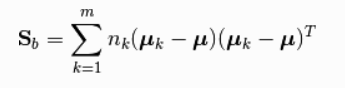
## Where nk is number of samples and m is number of classes


In [ ]:
#@title
all_classes_mean=np.mean(X_train,axis=0,keepdims=True)

In [ ]:
#@title
Sb=np.zeros((10304,10304))
all_classes_mean=all_classes_mean.reshape(10304,1)
for i in range(40):
  class_mean=classes_means[i].reshape(10304,1)
  Sb+=5*np.dot((class_mean-all_classes_mean),(class_mean-all_classes_mean).T)

## Center class matrix

In [ ]:
#@title
Z=[]
for i in range(40):
  centered=classes_matrix[i]-classes_means[i]
  Z.append(centered)

## Class sccatter matrix

In [ ]:
#@title
S=np.ones((10304,10304))
for i in range(40):
  S+=np.dot(Z[i].T,Z[i])

## Eigenvectors and eigenvalues

In [ ]:
#@title
eig_values,eig_vectors=np.linalg.eigh(np.dot(np.linalg.inv(S),Sb))

In [ ]:
#@title
eig_values = eig_values[::-1]
eig_vectors = eig_vectors[:,::-1]

In [ ]:
#@title
selected=eig_vectors[:,:39]
selected.shape

(10304, 39)

In [ ]:
#@title
X_train.shape

(200, 10304)

## Projecting data on the selected eigenvectors

In [ ]:
#@title
def project(data,proj_matrix):
  return np.dot(proj_matrix,data.T).T

In [ ]:
#@title
train_proj,test_proj=project(X_train,selected.T),project(X_test,selected.T)

## Applying KNN using different Ks

In [ ]:
#@title
train_proj,test_proj=LDA(X_train,X_test)
Ks=[1,3,5,7]
lda_accuracies=[]
for k in Ks:
  model=KNeighborsClassifier(n_neighbors=k)
  model.fit(train_proj, y_train)
  test_pred = model.predict(test_proj)
  acc=accuracy_score(y_test, test_pred)
  print("Accuracy using k = "+str(k)+" = "+str(acc))
  lda_accuracies.append(acc)


In [ ]:
#@title
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(Ks, lda_accuracies,'--bo', label='line with marker')
plt.title("Tunung K parameter using LDA")
plt.xlabel("K")
plt.ylabel("Accuracy")

## By comparing , PCA performs better than LDA in this problem

# Bonus 1
## Splittig 70% , 30 % instead of 50% , 50%

In [ ]:
X_train_new,X_test_new,y_train_new,y_test_new=train_test_split(images,labels,test_size=0.3,stratify=labels)

Eigenvectors shape = (10304, 10304)
r =  39
U shape = (10304, 39)
projected_training shape = (280, 39)
projected_testing shape = (120, 39)
0.9583333333333334
Eigenvectors shape = (10304, 10304)
r =  59
U shape = (10304, 59)
projected_training shape = (280, 59)
projected_testing shape = (120, 59)
0.95
Eigenvectors shape = (10304, 10304)
r =  91
U shape = (10304, 91)
projected_training shape = (280, 91)
projected_testing shape = (120, 91)
0.95
Eigenvectors shape = (10304, 10304)
r =  147
U shape = (10304, 147)
projected_training shape = (280, 147)
projected_testing shape = (120, 147)
0.9583333333333334


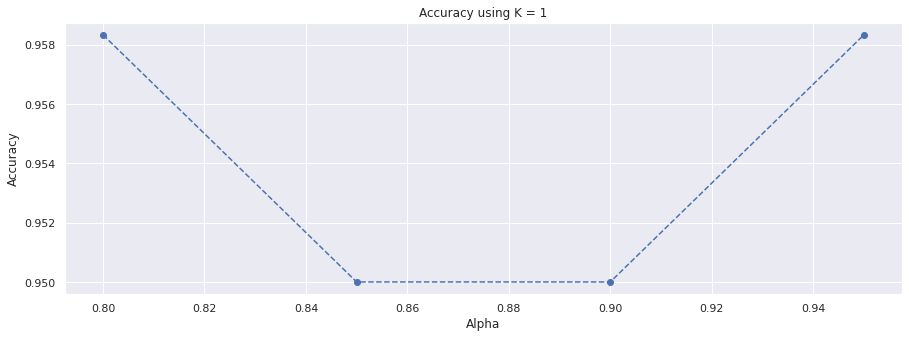

0.8833333333333333
0.9
0.9083333333333333
0.9166666666666666
Done for alpha = 0.95

0.8333333333333334
0.8666666666666667
0.85
0.8333333333333334
Done for alpha = 0.95

0.8166666666666667
0.8
0.8083333333333333
0.825
Done for alpha = 0.95



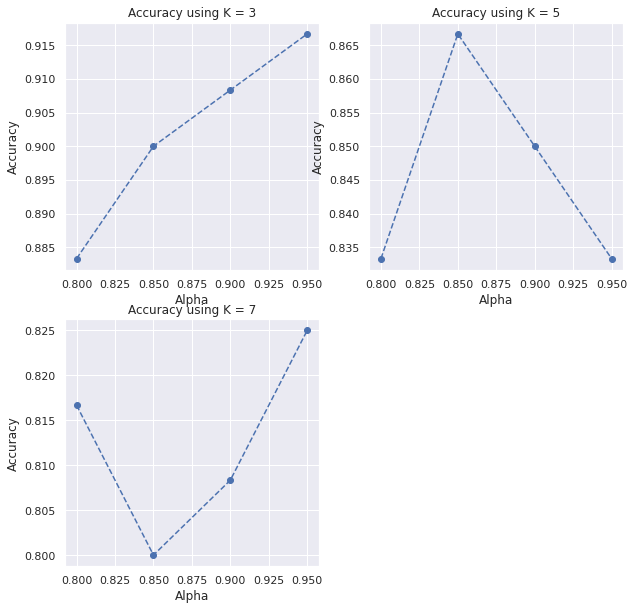

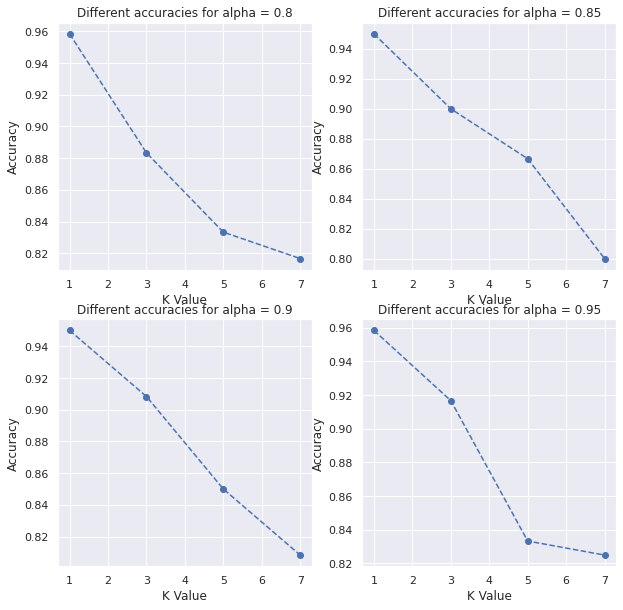

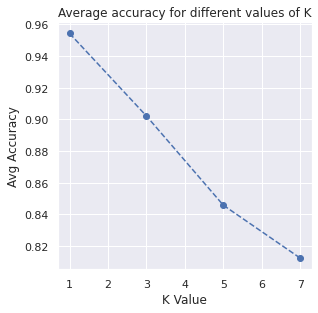

In [ ]:
test_pca(X_train_new,X_test_new,y_train_new,y_test_new)

Accuracy using k = 1 = 0.9416666666666667
Accuracy using k = 3 = 0.8333333333333334
Accuracy using k = 5 = 0.8083333333333333
Accuracy using k = 7 = 0.775


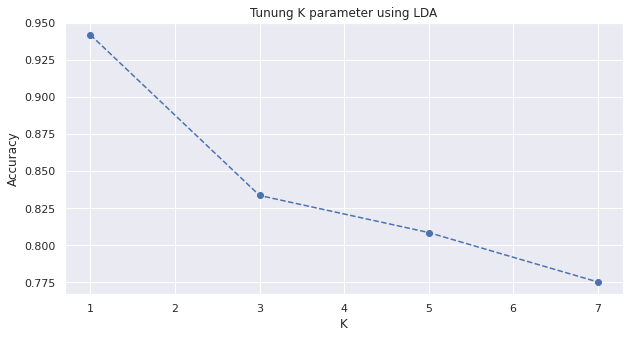

In [ ]:
test_lda(X_train_new,X_test_new,y_train_new,y_test_new)

# Bonus 2
## 1- PCA Variations

In [13]:
def classify_knn(X_train,X_test,y_train,y_test,k):
  model=KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  test_pred = model.predict(X_test)
  acc=accuracy_score(y_test, test_pred)
  print("Accuracy using k = "+str(k)+" = "+str(acc*100))

In [40]:
X_train.shape

(200, 10304)

### Randomized PCA

### The classical PCA uses the low-rank matrix approximation to estimate the principal components. However, this method becomes costly and makes the whole process difficult to scale, for large datasets.

### By randomizing how the singular value decomposition of the dataset happens, we can approximate the first K principal components quickly than classical PCA.



In [76]:
from sklearn.decomposition import PCA
rpca = PCA(n_components=91,svd_solver='randomized')
X_train_rpca = rpca.fit_transform(X_train)
X_test_rpca = rpca.transform(X_test)

In [77]:
Ks=[1,3,5,7]
for k in Ks:
  classify_knn(X_train_rpca,X_test_rpca,y_train,y_test,k)

Accuracy using k = 1 = 94.0
Accuracy using k = 3 = 84.5
Accuracy using k = 5 = 81.5
Accuracy using k = 7 = 75.0


### Incremental PCA

### Incremental PCA can be used when the dataset is too large to fit in the memory.Here we split the dataset into mini-batches where each batch can fit into the memory and then feed it one mini-batch at a moment to the IPCA algorithm.



In [99]:
from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=91,batch_size=100)
X_train_ipca = ipca.fit_transform(X_train)
X_test_ipca = ipca.transform(X_test)

In [100]:
Ks=[1,3,5,7]
for k in Ks:
  classify_knn(X_train_ipca,X_test_ipca,y_train,y_test,k)

Accuracy using k = 1 = 94.5
Accuracy using k = 3 = 84.0
Accuracy using k = 5 = 81.5
Accuracy using k = 7 = 73.5


### Kernel PCA
### Kernel PCA is a technique which uses the so-called kernel trick and projects the linearly inseparable data into a higher dimension where it is linearly separable

In [136]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=91, kernel='linear')
X_train_kpca = kpca.fit_transform(X_train)
X_test_kpca = kpca.transform(X_test)

In [137]:
Ks=[1,3,5,7]
for k in Ks:
  classify_knn(X_train_kpca,X_test_kpca,y_train,y_test,k)

Accuracy using k = 1 = 94.5
Accuracy using k = 3 = 84.0
Accuracy using k = 5 = 81.5
Accuracy using k = 7 = 73.5
